In [47]:
from IPython.display import SVG
import numpy as np
from scipy.stats import norm
import time
import pandas as pd 
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem
from keras import models
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from Bio import SeqIO
from Bio.PDB.Polypeptide import d1_to_index
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

In [48]:
""" Read csv file and return it as a panda dataframe(dictionary) by biopython """
def readfasta(ffile):
    """ Read fasta file, return dictionary """
    record_iterator = SeqIO.parse(ffile, "fasta")
    a=pd.DataFrame(columns=['id','seq'])
    for i in record_iterator:
        a.loc[a.shape[0]+1] = [i.id,str(i.seq[:])]
#     record_dict = SeqIO.to_dict(SeqIO.parse(ffile, "fasta"))
    #df1=pd.DataFrame(record_dict)   
    return a

In [49]:
"""Load Data as pandas dataframe"""
nondata = readfasta("C:/Users/DR/Desktop/P2/Latent-master/data/thermostability/non-thermophilic_proteins.txt")
data = readfasta("C:/Users/DR/Desktop/P2/Latent-master/data/thermostability/thermophilic_proteins.txt")
data['Thermostability']='1'
nondata['Thermostability']='0'

In [50]:
"""Data preprocessing"""
# Append the thermophilic to the non-thermophilic
data=pd.concat([data,nondata])
data=data.sample(frac=1)
# Init input and Y
X=data['seq']
Y=data['Thermostability']

The mean of the seq length is: 330.63524590163934
The S.D. of the seqs length is: 253.89479962847054


C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


'In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function \nof a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population\nare made, based on a finite data sample.'

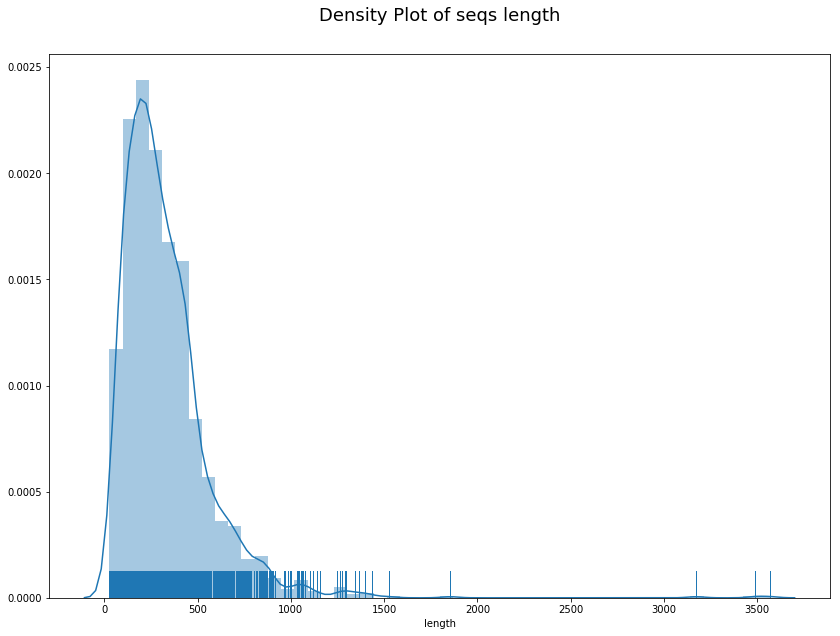

In [51]:
""" Visualize seq length """
# plot the histogram of solubility
import seaborn as sns
length=[]
for i in X:
    length.append(len(i))
train_y_plot = pd.Series( np.squeeze(length), name="length")
mean = train_y_plot.mean()
std = train_y_plot.std()
print("The mean of the seq length is: " + str(mean))
print("The S.D. of the seqs length is: " + str(std))
f,ax= plt.subplots(figsize = (14, 10))
sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
ax.set_title("Density Plot of seqs length", fontsize=18, position=(0.5,1.05))
plt.savefig('Density Plot of seqs length.svg', bbox_inches='tight')

"""In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function 
of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population
are made, based on a finite data sample."""

The frequency is: Counter({'L': 53531, 'A': 50534, 'G': 43643, 'V': 43613, 'E': 43415, 'I': 35336, 'K': 34816, 'R': 32726, 'D': 31297, 'S': 29990, 'T': 27349, 'P': 25605, 'F': 21545, 'N': 21151, 'Y': 18448, 'Q': 16743, 'M': 12832, 'H': 10729, 'W': 6661, 'C': 4756, '@': 2, 'X': 2, 'U': 1})
Amino acids type is: 23
They are: dict_keys(['M', 'K', 'F', 'I', 'E', 'A', 'L', 'R', 'V', 'P', 'H', 'N', 'T', 'G', 'S', 'D', 'W', 'Y', 'C', 'Q', 'U', '@', 'X'])


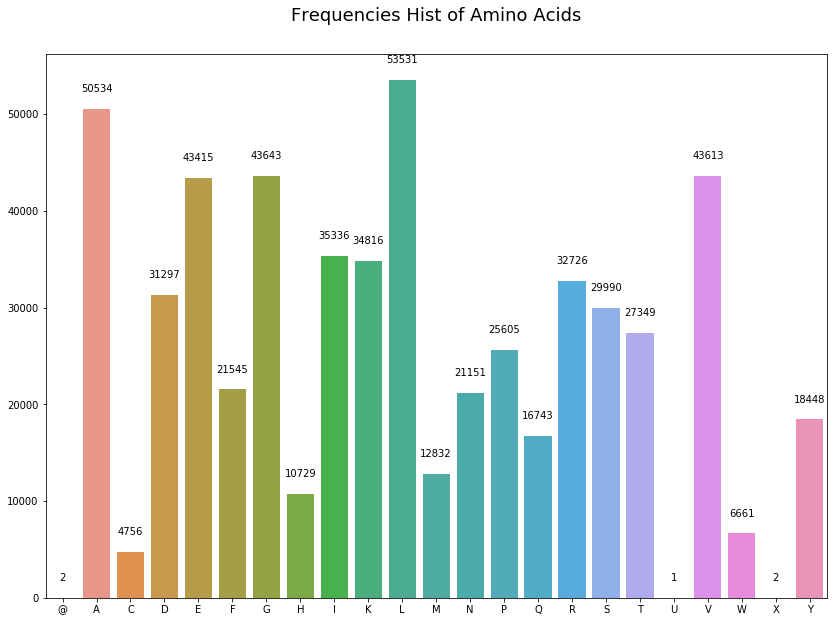

In [52]:
from collections import Counter

# Count amino acid
tmp=""
for i in X:
    tmp = tmp + str(i)
c2 = Counter(tmp)
print("The frequency is: " + str(c2))
print("Amino acids type is: " + str(len(c2)))
print("They are: " + str(c2.keys()))
k = pd.DataFrame.from_dict([c2])
classes=len(c2.keys())

f,ax= plt.subplots(figsize = (14, 10))
g=sns.barplot(data=k,ax=ax)
for p in g.patches:
        g.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
ax.set_title("Frequencies Hist of Amino Acids", fontsize=18, position=(0.5,1.05))
plt.savefig('Frequencies Hist of Amino Acids.svg', bbox_inches='tight')

# Sampling

In [53]:
d1_to_index =['M', 'T', 'K', 'S', 'I', 'Y', 'F', 'L', 'G', 'H', 'N', 'Q', 'P', 'V', 'D', 'E', 'R', 'A', 'W', 'C', '@', 'X', 'U']

# def _onehotencode(s, vocab=d1_to_index):
#     """ Function to one-hot encode a sring.
#     :param s: {str} String to encode in one-hot fashion
#     :param vocab: vocabulary to use fore encoding, if None, default AAs are used
#     :return: one-hot encoded string as a np.array
#     """
#     if not vocab:
#         vocab = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W',
#                  'Y', ' ']
    
#     # generate translation dictionary for one-hot encoding
#     to_one_hot = dict()
#     for i, a in enumerate(vocab):
#         v = np.zeros(len(vocab))
#         v[i] = 1
#         to_one_hot[a] = v
    
#     result = []
#     for l in s:
#         result.append(to_one_hot[l])
#     result = np.array(result)
#     return np.reshape(result, (1, result.shape[0], result.shape[1])), to_one_hot, vocab

def one_hot(seq):
    """ Convert amino acid to one-hot vector stack """
    # Generate amino acids one-hot dict
    to_one_hot = dict()
    for i, a in enumerate(d1_to_index):
        v = np.zeros(len(d1_to_index))
        v[i] = 1
        to_one_hot[a] = v
    ix = []
    result = []
    # Tranfer the seq by the dict
    for m in seq:
        result.append(to_one_hot[m])
    result = np.array(result)
    return np.reshape(result, (1, result.shape[0], result.shape[1]))

def index_seq(seq):
    """ Convert amino acid to numerical index """
    index=[]
    for i in seq:
        p=d1_to_index.index(i)
        index.append(p)
    index = index
    return index

def tensor_pad(seqs):
    # Init seqs vector
    seqs_index=[]
    # Transfer seqs into index vector
    for seq in seqs:
        seqs_index.append(index_seq(seq))
    # Pad the seqs
    pad=pad_sequences(seqs_index, maxlen=None, dtype='int32',padding='pre', truncating='pre', value=0.)
    # one-hot encode the pad
    encoded = to_categorical(pad)
    return encoded
    #return seqs_index

In [54]:
seqs_index=[]
for seq in list(X):
    seqs_index.append(index_seq(seq))
data=pad_sequences(seqs_index, maxlen=None, dtype='int32',padding='pre', truncating='pre', value=0.)

In [111]:
""" Hardmax the labels """
# convert train_y into a vector range from 0 to 1
def hardmax(Y_b4):
    Y_b4=np.array([int(i) for i in Y_b4.T])
    Y=np.zeros((1,len(Y_b4)))
    mean = Y_b4.mean()
    std = Y_b4.std()
    for i in range(0,len(Y_b4)-1):
        if (Y_b4[i] >=mean):
            Y[0][i]=1
        else:
            Y[0][i]=0

    print('There are '+ str(list(np.squeeze(Y)).count(1)) + ' soluble chemicals (positive samples) and ' + str(list(np.squeeze(Y)).count(0)) + ' insoluble chemicals (negative samples).')

    # plot the input fingerprint length distribution plot
    plt.plot(np.squeeze(Y))
    plt.ylabel('solubility')
    plt.xlabel('fingerprints')
    plt.title("fingerprint and solubility distribution in binary classification" )
    plt.show()
    
    return np.squeeze(Y)

In [56]:
"""NN Model"""
from keras import backend as K

# Customized R2 ACC method
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))
            
#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations)
         
def create_network(outputlayer_type='linear_regression',optimizer='Adam',number_of_features = 4096,Init='he_init'):
    # Setup hyperparameters for optimizers
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    sgd=optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    # Start neural network
    network = Sequential()
    network.add(Embedding(output_dim=32, input_dim=23, input_length=3567))
    network.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
    network.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
    network.add(LSTM(32))  # return a single vector of dimension 32
    
    if outputlayer_type=='linear_regression':

        # Add fully connected layer with a sigmoid activation function
        network.add(layers.Dense(units=1))

        # Compile neural network
        if optimizer == 'sgd':
            network.compile(loss='mean_squared_error',optimizer= sgd,metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
            print("1")
        elif optimizer == 'Adam':
            network.compile(loss='mean_squared_error',optimizer= Adam,metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
            print("2")
            
    elif outputlayer_type=='binary_classifier':

        # Add fully connected layer with a sigmoid activation function
        network.add(layers.Dense(units=1, activation='sigmoid'))

        # Compile neural network
        if optimizer == 'sgd':
            network.compile(loss='binary_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric sgd
            print("3")
        elif optimizer == 'Adam':
            network.compile(loss='binary_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric Adam
            print("4")
            
    # Return compiled network
    return network

In [57]:
import statsmodels.api as sm
import math

def get_r2_numpy(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return r_squared

def get_r2_scipy(x, y):
    _, _, r_value, _, _ = stats.linregress(x, y)
    return r_value**2

def get_r2_statsmodels(x, y):
    return sm.OLS(y, sm.add_constant(x)).fit().rsquared

In [58]:
# Plot linear regression
def linear_regression(Train_Y,Train_Y_pred,Test_Y,Test_Y_pred,path,i):
        r_square=get_r2_statsmodels(Train_Y_pred,Train_Y)
        q_square=get_r2_statsmodels(Test_Y_pred,Test_Y)
        
        # Plot Training-set
        model=LinearRegression()
        model.fit(Train_Y_pred,Train_Y)
        ax=plt.gca()
        plt.scatter(Train_Y_pred,Train_Y)
        y_train_pred=model.predict(Train_Y_pred)
        plt.title('Linear regression of solubility training prediction in fold '+str(i+1))
        plt.text(0.5,0.7,"The R-square value is %.2f " % r_square, verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(Train_Y_pred,y_train_pred,color='black',linewidth=3,label="R-square")
        plt.legend(loc=2)
        plt.xlabel("train  (mol/L)")
        plt.ylabel("theorical  (mol/L)")

        # Plot Testing-set
        model=LinearRegression()
        model.fit(Test_Y_pred,Test_Y)

        plt.scatter(Test_Y_pred,Test_Y)
        y_train_pred=model.predict(Test_Y_pred)

        plt.text(0.5,0.645,"The Q-square value is %.2f " % q_square,verticalalignment='bottom',color='red', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(Test_Y_pred,y_train_pred,color='red',linewidth=3,label="Q-square")
        plt.legend(loc=2)
        
        plt.savefig(path+'linear_regression_fold_'+str(i+1)+'.svg', bbox_inches='tight')
        plt.close()

In [2]:
# Linear regression INFO
class error_ana_info():
    def __init__(self):
        self._train_metric = None
        self._test_metric = None
        self.df = None
        self.mdif = None
    
    def add_info(self,train_metric,test_metric):
        if self._train_metric is None or  self._test_metric is None:
            self._train_metric = np.array(train_metric)
            self._test_metric = np.array(test_metric)
        else:
            self._train_metric = np.vstack((self._train_metric, train_metric))
            self._test_metric = np.vstack((self._test_metric, test_metric))
    
    def generate_csv(self,row_names,name):
        if (self._train_metric.size!=0 and self._test_metric.size!=0):
            _acc=[]
            _acc_in_val_acc=[]
            _valacc=[]
            _epochs=[]
            _train_err=[]

            # Calculate max train_acc
            for i in self._train_metric:
                _acc.append(np.max(i))

            # Calculate max test_acc and optimal_epo
            for index,i in enumerate(self._test_metric):
                _valacc.append(np.max(i))
                _epochs.append(np.where(i==np.max(i,axis=0))[0][0]+1)
                _acc_in_val_acc.append(self._train_metric[index][np.where(i==np.max(i,axis=0))[0][0]])
            
            print(_acc,_acc_in_val_acc)
            # Calculate max training_err
            for i in range(len(_acc)):
                _train_err.append('%.2f%%' %(((_acc[i]-_acc_in_val_acc[i])/_acc_in_val_acc[i])*100))
                
            self.df=[_acc,_acc_in_val_acc,_valacc,_epochs,_train_err]
            self.df = pd.DataFrame(self.df)
            self.df.set_index([row_names],inplace=True)
            
            # Calculate Average Value
            meanv=[]
            for index, row in self.df.iterrows():
                
                row=list(row)
                if re.search(r'\%',str(row[1])):
                    row=[float(j.strip("%")) for j in row]
                    meanv.append(str(np.mean(row))+"%")
                else:
                    row=[float(j) for j in row]
                    meanv.append(np.mean(list(row)))

            self.df['B']=meanv
            
            col=[]
            for i in range(1,len(self.df.iloc[0])):
                col.append("Fold "+str(i))
            col.append('Average Value')
            self.df.columns = col
            self.df.to_csv(name)
            
    def generate_model_info(self,epochs,batch_size,initialization,bias,name):
        Hyperparameters=pd.Series(data=['epochs','batch_size','initialization','bias'],name='Hyperparameters')
        Settings=pd.Series(data=[epochs,batch_size,initialization,bias],name='Settings')
        Settings.rename('Settings')
        self.mdif=pd.DataFrame()
        self.mdif= self.mdif.join(Hyperparameters, how='right')
        self.mdif= self.mdif.join(Settings)
        self.mdif.to_csv(name,index=False) 

SyntaxError: invalid syntax (<ipython-input-2-5c26b5444469>, line 50)

In [60]:
# define the training visualization function
def training_vis(hist,outputlayer,name):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    if outputlayer=='linear_regression':
        acc = hist.history['coeff_determination']
        val_acc = hist.history['val_coeff_determination']
    elif outputlayer=='binary_classifier':
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    if outputlayer=='linear_regression':
        ax2.plot(acc,label='train_coeff_determination')
        ax2.plot(val_acc,label='val_coeff_determination')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Coeff_determination')
        ax2.set_title('Coeff_determination  on Training and Validation Data')
    elif outputlayer=='binary_classifier':
        ax2.plot(acc,label='train_accuracy')
        ax2.plot(val_acc,label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy  on Training and Validation Data')
    
    ax2.legend()
    plt.tight_layout()
    plt.savefig(name, bbox_inches='tight')
    plt. close()

In [1]:
"""StratifiedKFold"""
from scipy import stats
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt
import matplotlib


def k_folds_NN(X=data,Y= Y,batch_size=5, epochs=5,path='C:/Users/DR/Desktop/P2/Latent-master/pic/Seq_linear_regression/',outputlayer_type='binary_classifier',optimizer='Adam',Init='he_init'):
    
    train_xx=X
    info=error_ana_info()
    if outputlayer_type=='binary_classifier':
        train_yy=hardmax(Y)
    else:
         train_yy=np.array([int(i) for i in Y.T])
            
#    train_yy=np.squeeze(train_yy)
    # Split the dataset in 3 folds
    sfolder = KFold(n_splits=3,random_state=0,shuffle=True)
    sfolder.get_n_splits(train_xx,train_yy)
    
    # If directory dosn't exixst, then create directory.  
    if not os.path.exists(path):
        os.mkdir(path)

#    early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=8,verbose=0, mode='auto')## Callback for early stopping the training
    
    #K-folds iteration    
    for i, (train, test) in enumerate(sfolder.split(train_xx,train_yy)):
        X_train, X_test = train_xx[train], train_xx[test]
        y_train, y_test = train_yy[train], train_yy[test]
        
        # Train the model with each combination of folds
        
        if Init=='he_init':
            network=create_network(outputlayer_type=outputlayer_type,optimizer=optimizer,number_of_features = X_train.shape[1],Init='he_init')
        elif Init=='random_no_bias':
            network=create_network(outputlayer_type=outputlayer_type,optimizer=optimizer,number_of_features = X_train.shape[1],Init='he_init')
        elif Init=='random_with_bias':
            network=create_network(outputlayer_type=outputlayer_type,optimizer=optimizer,number_of_features = X_train.shape[1],Init='he_init')
        
        hist = network.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test))
        
            
        if outputlayer_type=='linear_regression':
            # Plot Linear Regression
            info.add_info(hist.history['coeff_determination'],hist.history['val_coeff_determination'])
            linear_regression(Train_Y=y_train,Train_Y_pred=network.predict(X_train),Test_Y=y_test,Test_Y_pred=network.predict(X_test),path=path,i=i)
        elif outputlayer_type=='binary_classifier':
             info.add_info(hist.history['acc'],hist.history['val_acc'])
   #         linear_regression_info(hist.history['coeff_determination'],hist.history['val_coeff_determination'],path)
                   
    # hist = network.fit(X_train,  y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping])
              
        # Plot runtime
        training_vis(hist,outputlayer_type,path+"train_fold "+str(i+1)+".svg")
        #plt.cla()
        
        # Save NN Model
        network.save(path+'batch_size_'+str(batch_size)+'epochs_'+str(epochs)+'fold_'+str(i+1)+'.h5')
        
        i=i+1
        
    # Output training information
    if outputlayer_type=='linear_regression':
        info.generate_csv(['R2','R2_opt','Q2','Epochs_opt','Train_err'],path+"training_result.csv")
    elif outputlayer_type=='binary_classifier':
         info.generate_csv(['Train_Acc','Train_Acc_opt','Test_Acc','Epochs_opt','Train_err'],path+"training_result.csv")
    
    
    if Init=='he_init':
        info.generate_model_info(epochs,batch_size,"He_Init","Enabled",path+'model_info.csv')
    elif Init=='random_no_bias':
        info.generate_model_info(epochs,batch_size,"Random","False",path+'model_info.csv')
    elif Init=='random_with_bias':
        info.generate_model_info(epochs,batch_size,"Random","True",path+'model_info.csv')
    
    return hist

NameError: name 'data' is not defined

There are 914 soluble chemicals (positive samples) and 794 insoluble chemicals (negative samples).


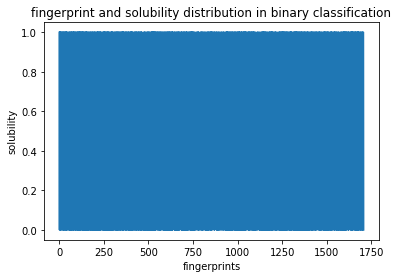

Train on 1138 samples, validate on 570 samples
Epoch 1/5
1138/1138 [==============================] - 1376s 1s/step - loss: 0.6594 - acc: 0.6239 - val_loss: 0.5565 - val_acc: 0.7754
Epoch 2/5
1138/1138 [==============================] - 1373s 1s/step - loss: 0.5391 - acc: 0.7627 - val_loss: 0.8962 - val_acc: 0.5456
Epoch 3/5
1138/1138 [==============================] - 1375s 1s/step - loss: 0.7004 - acc: 0.5272 - val_loss: 0.7522 - val_acc: 0.5281
Epoch 4/5
1138/1138 [==============================] - 1377s 1s/step - loss: 0.6447 - acc: 0.6450 - val_loss: 0.6916 - val_acc: 0.5263
Epoch 5/5
1138/1138 [==============================] - 1374s 1s/step - loss: 0.6920 - acc: 0.5431 - val_loss: 0.6914 - val_acc: 0.5263
Train on 1139 samples, validate on 569 samples
Epoch 1/5
1139/1139 [==============================] - 1373s 1s/step - loss: 0.5941 - acc: 0.6734 - val_loss: 0.4787 - val_acc: 0.8032
Epoch 2/5
1139/1139 [==============================] - 1378s 1s/step - loss: 0.6006 - acc: 0.683

In [112]:
# with_bias; Random_Init
history=k_folds_NN()

In [56]:
# data_dim = len(word_index) + 1
# timesteps = 8
# num_classes = 1

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(Embedding(output_dim=32, input_dim=23, input_length=3567))
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']) # Require label as one-hot encoded
print(model.summary())
model.fit(X_train,
          
          
          y_train,batch_size=5, epochs=5, validation_data=(X_test,  y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 3567, 32)          736       
_________________________________________________________________
lstm_10 (LSTM)               (None, 3567, 32)          8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3567, 32)          8320      
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 25,729
Trainable params: 25,729
Non-trainable params: 0
_________________________________________________________________
None
Train on 1537 samples, validate on 171 samples
Epoch 1/5
1537/1537 [==============================] - 1712s 1s/step - loss: 0.4855 - 

## Bidirectional LSTM

## Early Stopping

In [18]:
"""Hold-out method"""
# Split the data in train/test = 0.9/0.1
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.10)
y_test=[int(k) for k in y_test]
y_train=[int(k) for k in y_train]
# y_train=np.array([ int(i) for i in np.array(y_train)]).reshape(1537,1)
# y_test=np.array([ int(i) for i in np.array(y_test)]).reshape(171,1)
# X_train=X_train.reshape(1537,1, 3567)
# X_test=X_test.reshape(1537,1, 3567)
print("X_train: "+str(X_train.shape[:]))
print("X_test: "+str(X_test.shape[:]))
# print("y_train: "+str(y_train.shape[:]))
# print("y_test: "+str(y_test.shape[:]))

X_train: (1537, 3567)
X_test: (171, 3567)


In [57]:
# from keras.layers import Dense, Flatten, Input
# from keras.layers.embeddings import Embedding
# from keras.models import Model
# from keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.text import one_hot
# # define documents
# docs = ['Well done!',
#         'Good work',
#         'Great effort',
#         'nice work',
#         'Excellent!',
#         'Weak',
#         'Poor effort!',
#         'not good',
#         'poor work',
#         'Could have done better.']
# # define class labels
# labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
# # integer encode the documents
# vocab_size = 50
# encoded_docs = [one_hot(d, vocab_size) for d in docs]
# print(encoded_docs)
# # pad documents to a max length of 4 words
# max_length = 4
# padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# print(padded_docs)
# # define the model
# input = Input(shape=(4, ))
# x = Embedding(vocab_size, 8, input_length=max_length)(input)
# x = Flatten()(x)
# x = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=input, outputs=x)
# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# # summarize the model
# print(model.summary())
# # fit the model
# model.fit(padded_docs, labels, epochs=50, verbose=0)
# # evaluate the model
# loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
# print('Accuracy: %f' % (accuracy * 100))

In [9]:
# def one_hot_encode(seqs,window,step, target='all'):
#         """ Chop up loaded sequences into patterns of length ``window`` by moving by stepsize ``step`` and translate
#         them with a one-hot vector encoding
#         :param target: {str} whether all proceeding AA should be learned or just the last one in sequence (`all`, `one`)
#         :return: one-hot encoded sequence patterns in self.X and corresponding target amino acids in self.y
#         """
#         X=[]
#         if self.window == 0:
#             for seq in seqs:
#                 X.append([one_hot[char] for char in seq[:-step]])
# #                 if target == 'all':
# #                     y.append([one_hot[char] for char in seq[self.step:]])
# #                 elif target == 'one':
# #                     y.append(seq[-step:])
            
#             X = np.reshape(X, (len(X), len(self.sequences[0]) - step, len(d1_to_index)))
# #            self.y = np.reshape(self.y, (len(self.y), len(self.sequences[0]) - self.step, len(self.vocab)))
        
#         else:
#             for s in self.sequences:
#                 for i in range(0, len(s) - self.window, self.step):
#                     self.X.append([self.to_one_hot[char] for char in s[i: i + self.window]])
#                     if target == 'all':
#                         self.y.append([self.to_one_hot[char] for char in s[i + 1: i + self.window + 1]])
#                     elif target == 'one':
#                         self.y.append(s[-self.step:])
            
#             self.X = np.reshape(self.X, (len(self.X), self.window, len(self.vocab)))
#             self.y = np.reshape(self.y, (len(self.y), self.window, len(self.vocab)))
        
#         print("\nData shape:\nX: " + str(self.X.shape) + "\ny: " + str(self.y.shape))

# def tensorSeq(seqs, MAX_SEQ_LENGTH, SEQDEPTH, TOKEN_SIZE=20):
#     """ Encode an amino acid sequence as a tensor 
#     by concatenating one-hot encoding up to desired depth """
#     TRAIN_BATCH_SIZE = len(seqs)
#     Xs = np.zeros( (TRAIN_BATCH_SIZE, MAX_SEQ_LENGTH, SEQDEPTH*TOKEN_SIZE) )
#     for i in range(0, len(seqs)):
#         seq_one_hot = one_hot( seqs[i] )
#         for l in range(0, MAX_SEQ_LENGTH):
#             for k in range(0, SEQDEPTH):
#                 try:
#                     Xs[i, l, seq_one_hot[l+k] + TOKEN_SIZE*k] = 1
#                 except:
#                     continue
#     """ Flip sequences (zero-padding at the start) """
#     Xsr = np.flip( Xs, 1 )
#     return Xsr, Xs